# Semantic Segmentation

In this exercise we will train an end-to-end convolutional neural network for semantic segmentation.
The goal of semantic segmentation is to classify the image on the pixel level, for each pixel
we want to determine the class of the object to which it belongs. This is different from image classification
which classifies an image as a whole and doesn't tell us the location of the objects. This is why semantic segmentation goes into category of structured prediction problems. It answers on both the 'what' and 'where' questions while classfication tells us only 'what'.

Input image | Target image
-|-
![raw](assets/frankfurt_000000_014480.png) | ![raw](assets/frankfurt_000000_014480_labels.png)
![raw](assets/frankfurt_000001_005898.png) | ![raw](assets/frankfurt_000001_005898_labels.png)


## 1. Cityscapes dataset

[Cityscapes dataset](https://www.cityscapes-dataset.com/dataset-overview/) contains a diverse set of stereo video sequences recorded in street scenes from 50 different cities, with high quality pixel-level annotations. Dataset contains 2975 training and 500 validation images of size 2048x1024. The test set of 1000 images is evaluated on the server and benchmark is available [here](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task). Here we will use downsampled images of size 384x160. The original dataset has 19 classes but we lowered that to 7 by uniting similar classes. This makes sense due to low visibility of very small objects in downsampled images. We also have ignore class which we need to ignore during training.

* Download the prepared dataset [here]() and extract it to the current directory. 

ID | Class | Color
-|-|-
0 | road | purple
1 | building | grey
2 | infrastructure | yellow
3 | nature | green
4 | sky | light blue
5 | person | red
6 | vehicle | dark blue
7 | ignore | black

## 2. Building the graph

Let's begin by importing all the modules and setting the fixed random seed.

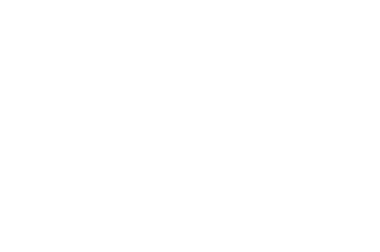

In [1]:
%matplotlib inline

import time
from os.path import join

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import utils
from data import Dataset

tf.set_random_seed(31415)
tf.logging.set_verbosity(tf.logging.ERROR)

plt.axis('off')
plt.rcParams["figure.figsize"] = (15, 5)

### Dataset

The `Dataset` class implements an iterator which returns the next batch data in each iteration. Data is already normalized to have zero mean and unit variance. The iteration is terminated when we reach the end of the dataset (one epoch).

In [2]:
batch_size = 10
num_classes = Dataset.num_classes
# create the Dataset for training and validation
train_data = Dataset('train', batch_size)
val_data = Dataset('val', batch_size, shuffle=False)

print('Train shape:', train_data.x.shape)
print('Validation shape:', val_data.x.shape)

print('mean = ', train_data.x.mean((0,1,2)))
print('std = ', train_data.x.std((0,1,2)))

Train shape: (2975, 160, 384, 3)
Validation shape: (500, 160, 384, 3)
mean =  [-0.03841928 -0.04215339 -0.05894543]
std =  [ 1.01808784  1.02022915  1.02732566]


### Inputs

First, we will create input placeholders for Tensorflow computational graph of the model. For a supervised learning model, we need to declare placeholders which will hold input images (x) and target labels (y) of the mini-batches as we feed them to the network.

In [3]:
# store the input image dimensions
height = train_data.height
width = train_data.width
channels = train_data.channels

# create placeholders for inputs
def build_inputs():
    with tf.name_scope('data'):
        x = tf.placeholder(tf.float32, shape=(None, height, width, channels), name='rgb_images')
        y = tf.placeholder(tf.int32, shape=(None, height, width), name='labels')
    return x, y

### Model

Now we can define the computational graph. Here we will heavily use [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) high level API which handles `tf.Variable` creation for us. The main difference here compared to the classification model is that the network is going to be fully convolutional without any fully connected layers.

In [4]:
# helper function which applies conv2d + ReLU with filter size k
def conv(x, num_maps, k=3):
    x = tf.layers.conv2d(x, num_maps, k, padding='same')
    x = tf.nn.relu(x)
    return x

# helper function for 2x2 max pooling with stride=2
def pool(x):
    return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='same')

# this functions takes the input placeholder and the number of classes, builds the model and returns the logits
def build_model(x, num_classes):
    input_size = x.get_shape().as_list()[1:3]
    block_sizes = [64, 64, 64, 64]
    x = conv(x, 32, k=3)
    for i, size in enumerate(block_sizes):
        with tf.name_scope('block'+str(i)):
            x = pool(x)
            x = conv(x, size)
            x = conv(x, size)
    print(x)
    with tf.name_scope('logits'):
        x = tf.layers.conv2d(x, num_classes, 1, padding='same')
        x = tf.image.resize_bilinear(x, input_size, name='upsample_logits')
    return x

### Loss

Now we are going to implement the `build_loss` funcion which will create operations for loss computation and return the final `tf.Tensor` holding the scalar loss value.
Because segmentation is just classification on a pixel level we can again use the cross entropy loss function \\(L\\) between the target one-hot distribution \\( \mathbf{y} \\) and the predicted distribution from a softmax layer \\( \mathbf{s} \\). But compared to image clasificaion here we need to define the loss at each pixel. Below are the equations describing the loss for one example (one pixel in our case).
$$
L = - \sum_{i=1}^{C} y_i log(s_j(\mathbf{x})) \\
s_i(\mathbf{x}) = \frac{e^{x_i}}{\sum_{j=1}^{C} e^{x_j}} \\
$$

In [5]:
# this funcions takes logits and targets (y) and builds the loss subgraph
def build_loss(logits, y):
  with tf.name_scope('loss'):
    # vectorize the image
    y = tf.reshape(y, shape=[-1])
    logits = tf.reshape(logits, [-1, num_classes])
    
    # gather all labels with valid ID
    mask = y < num_classes
    y = tf.boolean_mask(y, mask)
    logits = tf.boolean_mask(logits, mask)

    y_one_hot = tf.one_hot(y, num_classes)
    xent = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)

    xent = tf.reduce_mean(xent)
    tf.summary.scalar('cross_entropy', xent)
    return xent

### Putting it all together

Now we can use all the building blocks from above and construct the whole Tensorflow graph in just a couple of lines.

In [6]:
# create inputs
x, y = build_inputs()
# create model
logits = build_model(x, num_classes)
# create loss
loss = build_loss(logits, y)
# we are going to need argmax predictions for IoU
y_pred = tf.argmax(logits, axis=3, output_type=tf.int32)

Tensor("block3/Relu_1:0", shape=(?, 10, 24, 64), dtype=float32)


## 3. Training the model

### Validation

We usually evaluate the semantic segmentation results with [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) measure (IoU aka Jaccard index). Note that accurracy we used on MNIST image classification problem is a bad measure in this case because semantic segmentation datasets are often heavily imbalanced. First we compute IoU for each class in one-vs-all fashion (shown below) and then take the mean IoU (mIoU) over all classes. By taking the mean we are treating all classes as equally important.
$$
IOU = \frac{TP}{TP + FN + FP}
$$

![iou](assets/iou.png)

In [7]:
def validate(sess, data, x, y, y_pred, loss, draw_steps=0):
    print('\nValidation phase:')
    conf_mat = np.zeros((num_classes, num_classes), dtype=np.uint64) 
    for i, (x_np, y_np, names) in enumerate(data):
        start_time = time.time()
        loss_np, y_pred_np = sess.run([loss, y_pred],
          feed_dict={x: x_np, y: y_np})

        duration = time.time() - start_time
        batch_conf_mat = confusion_matrix(y_np.reshape(-1), y_pred_np.reshape(-1))
        batch_conf_mat = batch_conf_mat[:-1,:-1].astype(np.uint64)
        conf_mat += batch_conf_mat

        for j in range(min(draw_steps, batch_size)):
            img_pred = utils.colorize_labels(y_pred_np[j], Dataset.class_info)
            img_true = utils.colorize_labels(y_np[j], Dataset.class_info)
            img_raw = data.get_img(names[j])
            img = np.concatenate((img_raw, img_true, img_pred), axis=1)
            plt.imshow(img)
            plt.show()
            draw_steps -= 1

        if i % 10 == 0:
            string = 'batch %03d loss = %.2f  (%.1f images/sec)' % \
            (i, loss_np, x_np.shape[0] / duration)
            print(string)
    print(conf_mat)
    return utils.print_stats(conf_mat, 'Validation', Dataset.class_info)

### Training

In [8]:
def train(sess, x, y, y_pred, loss, checkpoint_dir):
    num_epochs = 30
    batch_size = 10
    log_dir = 'local/logs'
    utils.clear_dir(log_dir)
    utils.clear_dir(checkpoint_dir)

    learning_rate = 1e-3
    decay_power = 1.0

    global_step = tf.Variable(0, trainable=False)
    decay_steps = num_epochs * train_data.num_batches

    lr = tf.train.polynomial_decay(learning_rate, global_step, decay_steps,
                                   end_learning_rate=0, power=decay_power)

    train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    summary_all = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(join(log_dir, 'train'), sess.graph)

    tf.global_variables_initializer().run(session=sess)

    step = 0
    best_iou = 0
    best_epoch = 0
    exp_start_time = time.time()
    for epoch in range(1, num_epochs+1):
        # confusion_mat = np.zeros((num_classes, num_classes), dtype=np.uint64)
        print('\nTraining phase:')
        for x_np, y_np, names in train_data:
            start_time = time.time()
            loss_np, summary, _ = sess.run([loss, summary_all, train_step],
            feed_dict={x: x_np, y: y_np})
            train_writer.add_summary(summary, step)
            duration = time.time() - start_time
            # confusion_mat += batch_conf_mat.astype(np.uint64)
            if step % 20 == 0:
                string = '%s: epoch %d / %d, iter %05d, loss = %.2f  (%.1f images/sec)' % \
                (utils.get_expired_time(exp_start_time), epoch, num_epochs, step, loss_np, batch_size / duration)
                print(string)
            step += 1
        # utils.print_metrics(confusion_mat, 'Train') 
        iou = validate(sess, val_data, x, y, y_pred, loss, draw_steps=0)
        if iou > best_iou:
            best_iou, best_epoch = iou, epoch
            save_path = saver.save(sess, join(checkpoint_dir, 'model.ckpt'))
            print('Model saved in file: ', save_path)
        print('\nBest IoU = %.2f (epoch %d)' % (best_iou, best_epoch))

In [9]:
sess = tf.Session()
train(sess, x, y, y_pred, loss, 'local/checkpoint1')

/usr/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Training phase:
00:00:01: epoch 1 / 30, iter 00000, loss = 1.94  (13.4 images/sec)
00:00:01: epoch 1 / 30, iter 00020, loss = 0.99  (300.1 images/sec)
00:00:02: epoch 1 / 30, iter 00040, loss = 0.88  (302.4 images/sec)
00:00:03: epoch 1 / 30, iter 00060, loss = 0.96  (301.5 images/sec)
00:00:03: epoch 1 / 30, iter 00080, loss = 0.78  (302.1 images/sec)
00:00:04: epoch 1 / 30, iter 00100, loss = 0.87  (300.8 images/sec)
00:00:05: epoch 1 / 30, iter 00120, loss = 0.68  (299.4 images/sec)
00:00:05: epoch 1 / 30, iter 00140, loss = 0.93  (300.3 images/sec)
00:00:06: epoch 1 / 30, iter 00160, loss = 0.70  (303.6 images/sec)
00:00:07: epoch 1 / 30, iter 00180, loss = 0.71  (304.6 images/sec)
00:00:07: epoch 1 / 30, iter 00200, loss = 0.60  (299.7 images/sec)
00:00:08: epoch 1 / 30, iter 00220, loss = 0.59  (298.0 images/sec)
00:00:09: epoch 1 / 30, iter 00240, loss = 0.48  (301.4 images/sec)
00:00:09: epoch 1 / 30, iter 00260, loss = 0.50  (304.0 images/sec)
00:00:10: epoch 1 / 30, iter 002

Model saved in file:  local/checkpoint1/model.ckpt

Best IoU = 57.18 (epoch 4)

Training phase:
00:01:34: epoch 5 / 30, iter 01200, loss = 0.41  (300.6 images/sec)
00:01:34: epoch 5 / 30, iter 01220, loss = 0.34  (297.8 images/sec)
00:01:35: epoch 5 / 30, iter 01240, loss = 0.34  (295.2 images/sec)
00:01:36: epoch 5 / 30, iter 01260, loss = 0.34  (304.2 images/sec)
00:01:36: epoch 5 / 30, iter 01280, loss = 0.31  (302.5 images/sec)
00:01:37: epoch 5 / 30, iter 01300, loss = 0.35  (297.1 images/sec)
00:01:38: epoch 5 / 30, iter 01320, loss = 0.37  (300.0 images/sec)
00:01:38: epoch 5 / 30, iter 01340, loss = 0.34  (301.2 images/sec)
00:01:39: epoch 5 / 30, iter 01360, loss = 0.40  (301.9 images/sec)
00:01:40: epoch 5 / 30, iter 01380, loss = 0.31  (300.9 images/sec)
00:01:40: epoch 5 / 30, iter 01400, loss = 0.28  (301.4 images/sec)
00:01:41: epoch 5 / 30, iter 01420, loss = 0.36  (295.6 images/sec)
00:01:42: epoch 5 / 30, iter 01440, loss = 0.32  (299.4 images/sec)
00:01:42: epoch 5 / 

Model saved in file:  local/checkpoint1/model.ckpt

Best IoU = 59.80 (epoch 8)

Training phase:
00:03:06: epoch 9 / 30, iter 02400, loss = 0.30  (300.2 images/sec)
00:03:07: epoch 9 / 30, iter 02420, loss = 0.32  (299.4 images/sec)
00:03:08: epoch 9 / 30, iter 02440, loss = 0.32  (301.3 images/sec)
00:03:08: epoch 9 / 30, iter 02460, loss = 0.34  (300.9 images/sec)
00:03:09: epoch 9 / 30, iter 02480, loss = 0.26  (300.4 images/sec)
00:03:10: epoch 9 / 30, iter 02500, loss = 0.29  (299.0 images/sec)
00:03:10: epoch 9 / 30, iter 02520, loss = 0.27  (302.8 images/sec)
00:03:11: epoch 9 / 30, iter 02540, loss = 0.30  (302.1 images/sec)
00:03:12: epoch 9 / 30, iter 02560, loss = 0.31  (301.9 images/sec)
00:03:12: epoch 9 / 30, iter 02580, loss = 0.32  (301.9 images/sec)
00:03:13: epoch 9 / 30, iter 02600, loss = 0.35  (299.1 images/sec)
00:03:14: epoch 9 / 30, iter 02620, loss = 0.42  (301.0 images/sec)
00:03:14: epoch 9 / 30, iter 02640, loss = 0.39  (301.0 images/sec)
00:03:15: epoch 9 / 

00:04:38: epoch 13 / 30, iter 03580, loss = 0.34  (299.5 images/sec)
00:04:38: epoch 13 / 30, iter 03600, loss = 0.29  (299.1 images/sec)
00:04:39: epoch 13 / 30, iter 03620, loss = 0.26  (302.1 images/sec)
00:04:40: epoch 13 / 30, iter 03640, loss = 0.26  (297.8 images/sec)
00:04:40: epoch 13 / 30, iter 03660, loss = 0.25  (301.9 images/sec)
00:04:41: epoch 13 / 30, iter 03680, loss = 0.27  (301.9 images/sec)
00:04:42: epoch 13 / 30, iter 03700, loss = 0.32  (302.9 images/sec)
00:04:42: epoch 13 / 30, iter 03720, loss = 0.26  (294.3 images/sec)
00:04:43: epoch 13 / 30, iter 03740, loss = 0.25  (293.0 images/sec)
00:04:44: epoch 13 / 30, iter 03760, loss = 0.27  (297.7 images/sec)
00:04:44: epoch 13 / 30, iter 03780, loss = 0.28  (301.7 images/sec)
00:04:45: epoch 13 / 30, iter 03800, loss = 0.27  (299.2 images/sec)
00:04:46: epoch 13 / 30, iter 03820, loss = 0.26  (303.7 images/sec)
00:04:46: epoch 13 / 30, iter 03840, loss = 0.31  (301.5 images/sec)
00:04:47: epoch 13 / 30, iter 0386

00:06:09: epoch 17 / 30, iter 04780, loss = 0.25  (315.1 images/sec)
00:06:10: epoch 17 / 30, iter 04800, loss = 0.26  (303.6 images/sec)
00:06:11: epoch 17 / 30, iter 04820, loss = 0.32  (301.2 images/sec)
00:06:11: epoch 17 / 30, iter 04840, loss = 0.25  (302.8 images/sec)
00:06:12: epoch 17 / 30, iter 04860, loss = 0.21  (301.3 images/sec)
00:06:13: epoch 17 / 30, iter 04880, loss = 0.27  (301.5 images/sec)
00:06:13: epoch 17 / 30, iter 04900, loss = 0.28  (301.8 images/sec)
00:06:14: epoch 17 / 30, iter 04920, loss = 0.24  (302.9 images/sec)
00:06:15: epoch 17 / 30, iter 04940, loss = 0.26  (299.4 images/sec)
00:06:15: epoch 17 / 30, iter 04960, loss = 0.27  (302.4 images/sec)
00:06:16: epoch 17 / 30, iter 04980, loss = 0.31  (299.2 images/sec)
00:06:17: epoch 17 / 30, iter 05000, loss = 0.29  (301.6 images/sec)
00:06:17: epoch 17 / 30, iter 05020, loss = 0.29  (297.2 images/sec)
00:06:18: epoch 17 / 30, iter 05040, loss = 0.27  (301.8 images/sec)
00:06:19: epoch 17 / 30, iter 0506

Model saved in file:  local/checkpoint1/model.ckpt

Best IoU = 64.51 (epoch 20)

Training phase:
00:07:41: epoch 21 / 30, iter 05960, loss = 0.24  (297.6 images/sec)
00:07:42: epoch 21 / 30, iter 05980, loss = 0.24  (297.6 images/sec)
00:07:43: epoch 21 / 30, iter 06000, loss = 0.23  (294.6 images/sec)
00:07:43: epoch 21 / 30, iter 06020, loss = 0.25  (297.9 images/sec)
00:07:44: epoch 21 / 30, iter 06040, loss = 0.23  (302.7 images/sec)
00:07:45: epoch 21 / 30, iter 06060, loss = 0.22  (303.3 images/sec)
00:07:45: epoch 21 / 30, iter 06080, loss = 0.26  (302.1 images/sec)
00:07:46: epoch 21 / 30, iter 06100, loss = 0.33  (295.4 images/sec)
00:07:47: epoch 21 / 30, iter 06120, loss = 0.29  (301.2 images/sec)
00:07:47: epoch 21 / 30, iter 06140, loss = 0.24  (313.6 images/sec)
00:07:48: epoch 21 / 30, iter 06160, loss = 0.23  (301.5 images/sec)
00:07:49: epoch 21 / 30, iter 06180, loss = 0.23  (301.8 images/sec)
00:07:49: epoch 21 / 30, iter 06200, loss = 0.24  (299.0 images/sec)
00:07:

Model saved in file:  local/checkpoint1/model.ckpt

Best IoU = 65.72 (epoch 24)

Training phase:
00:09:14: epoch 25 / 30, iter 07160, loss = 0.23  (300.8 images/sec)
00:09:14: epoch 25 / 30, iter 07180, loss = 0.25  (285.9 images/sec)
00:09:15: epoch 25 / 30, iter 07200, loss = 0.24  (299.4 images/sec)
00:09:16: epoch 25 / 30, iter 07220, loss = 0.21  (299.2 images/sec)
00:09:16: epoch 25 / 30, iter 07240, loss = 0.22  (291.6 images/sec)
00:09:17: epoch 25 / 30, iter 07260, loss = 0.21  (300.1 images/sec)
00:09:18: epoch 25 / 30, iter 07280, loss = 0.24  (298.0 images/sec)
00:09:18: epoch 25 / 30, iter 07300, loss = 0.18  (300.3 images/sec)
00:09:19: epoch 25 / 30, iter 07320, loss = 0.25  (301.4 images/sec)
00:09:20: epoch 25 / 30, iter 07340, loss = 0.24  (302.4 images/sec)
00:09:20: epoch 25 / 30, iter 07360, loss = 0.23  (299.9 images/sec)
00:09:21: epoch 25 / 30, iter 07380, loss = 0.22  (304.6 images/sec)
00:09:22: epoch 25 / 30, iter 07400, loss = 0.20  (300.8 images/sec)
00:09:

00:10:45: epoch 29 / 30, iter 08360, loss = 0.19  (301.0 images/sec)
00:10:46: epoch 29 / 30, iter 08380, loss = 0.26  (302.7 images/sec)
00:10:47: epoch 29 / 30, iter 08400, loss = 0.20  (319.5 images/sec)
00:10:47: epoch 29 / 30, iter 08420, loss = 0.25  (302.0 images/sec)
00:10:48: epoch 29 / 30, iter 08440, loss = 0.24  (300.5 images/sec)
00:10:49: epoch 29 / 30, iter 08460, loss = 0.20  (299.4 images/sec)
00:10:49: epoch 29 / 30, iter 08480, loss = 0.21  (301.6 images/sec)
00:10:50: epoch 29 / 30, iter 08500, loss = 0.19  (300.1 images/sec)
00:10:51: epoch 29 / 30, iter 08520, loss = 0.21  (304.3 images/sec)
00:10:51: epoch 29 / 30, iter 08540, loss = 0.19  (299.4 images/sec)
00:10:52: epoch 29 / 30, iter 08560, loss = 0.21  (302.4 images/sec)
00:10:53: epoch 29 / 30, iter 08580, loss = 0.18  (300.6 images/sec)
00:10:53: epoch 29 / 30, iter 08600, loss = 0.26  (301.3 images/sec)
00:10:54: epoch 29 / 30, iter 08620, loss = 0.26  (300.1 images/sec)
00:10:55: epoch 29 / 30, iter 0864

## 4. Restoring the pretrained network

INFO:tensorflow:Restoring parameters from local/pretrained1/model.ckpt

Validation phase:


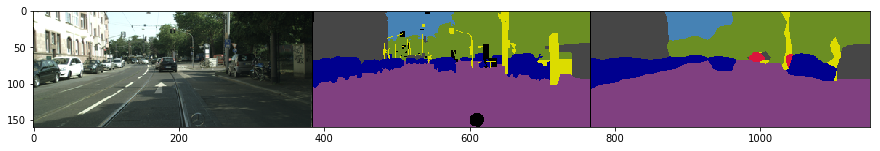

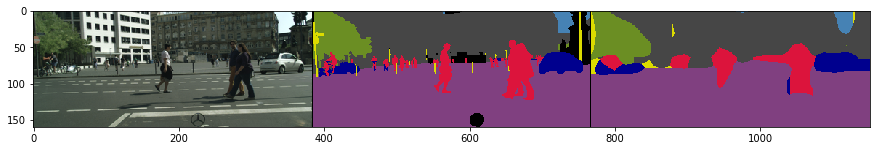

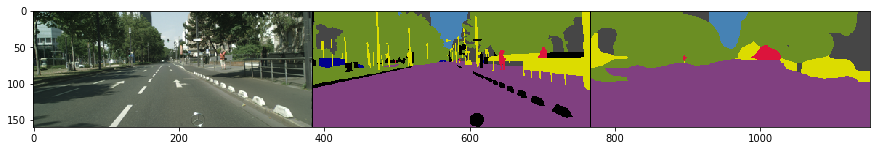

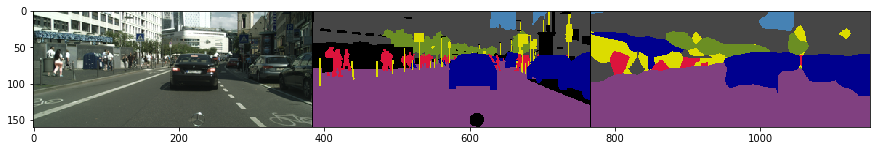

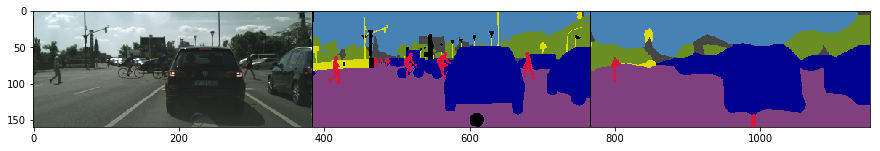

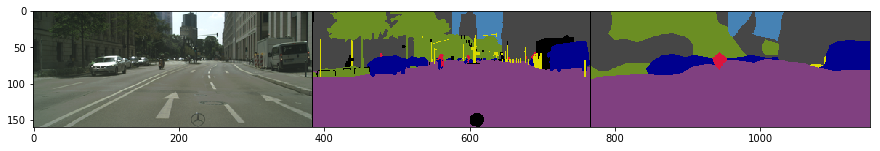

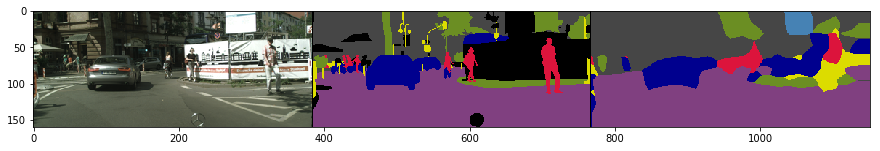

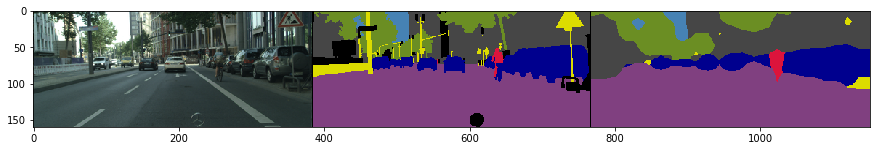

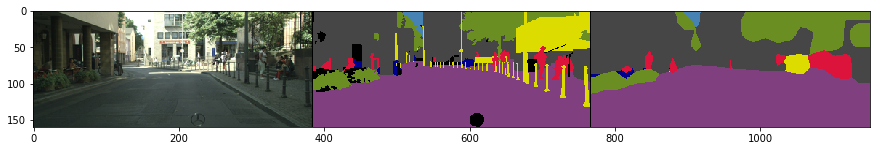

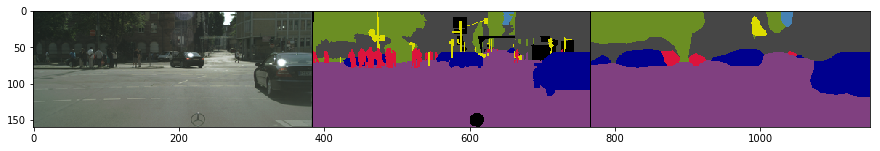

batch 000 loss = 0.33  (693.5 images/sec)
batch 010 loss = 0.32  (691.7 images/sec)
batch 020 loss = 0.39  (704.2 images/sec)
batch 030 loss = 0.24  (695.0 images/sec)
batch 040 loss = 0.26  (695.1 images/sec)
[[11490361    48276    32824    39771      131    39269   109990]
 [   84931  6144263    86356   312033    51630    55713   131930]
 [   82169   411167   180475   208681    12875    32077    58501]
 [   80607   307245    53075  4918982    34253    15614    57081]
 [       0    39900     3463    39217   824041        0      250]
 [   39805    85263    11503    24484       76   262299    55558]
 [   97240   129648    19698    56965      888    50981  2200621]]

 Validation  evaluation metrics:
	road IoU accuracy = 94.61 %
	building IoU accuracy = 77.89 %
	infrastructure IoU accuracy = 15.13 %
	nature IoU accuracy = 80.01 %
	sky IoU accuracy = 81.85 %
	person IoU accuracy = 39.00 %
	vehicle IoU accuracy = 74.11 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 66.09 %
Validat

66.085190395231365

In [12]:
# restore the best checkpoint
checkpoint_path = 'local/pretrained1/model.ckpt'
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)
validate(sess, val_data, x, y, y_pred, loss, draw_steps=10)

## Day 4

## 5. Improved model with skip connections

In this part we are going to improve on the pravious model by adding skip connections.

In [13]:
def upsample(x, skip, num_maps):
    skip_size = skip.get_shape().as_list()[1:3]
    x = tf.image.resize_bilinear(x, skip_size)
    x = tf.concat([x, skip], 3)
    return conv(x, num_maps)

# this functions takes the input placeholder and the number of classes, builds the model and returns the logits
def build_model(x, num_classes):
    input_size = x.get_shape().as_list()[1:3]
    block_sizes = [64, 64, 64, 64]
    skip_layers = []
    
    x = conv(x, 32, k=3)
    for i, size in enumerate(block_sizes):
        with tf.name_scope('block'+str(i)):
            x = pool(x)
            x = conv(x, size)
            x = conv(x, size)
            skip_layers.append(x)
    
    for i, skip in reversed(list(enumerate(skip_layers))):
        with tf.name_scope('block'+str(i)):
            print(i, x, '\n', skip)
            x = upsample(x, skip, block_sizes[i])
    
    with tf.name_scope('logits'):
        x = tf.layers.conv2d(x, num_classes, 1, padding='same')
        x = tf.image.resize_bilinear(x, input_size, name='upsample_logits')
    return x

In [14]:
sess.close()
tf.reset_default_graph()

# create inputs
x, y = build_inputs()
# create model
logits = build_model(x, num_classes)
# create loss
loss = build_loss(logits, y)
# we are going to need argmax predictions for IoU
y_pred = tf.argmax(logits, axis=3, output_type=tf.int32)

3 Tensor("block3/Relu_1:0", shape=(?, 10, 24, 64), dtype=float32) 
 Tensor("block3/Relu_1:0", shape=(?, 10, 24, 64), dtype=float32)
2 Tensor("block3_1/Relu:0", shape=(?, 10, 24, 64), dtype=float32) 
 Tensor("block2/Relu_1:0", shape=(?, 20, 48, 64), dtype=float32)
1 Tensor("block2_1/Relu:0", shape=(?, 20, 48, 64), dtype=float32) 
 Tensor("block1/Relu_1:0", shape=(?, 40, 96, 64), dtype=float32)
0 Tensor("block1_1/Relu:0", shape=(?, 40, 96, 64), dtype=float32) 
 Tensor("block0/Relu_1:0", shape=(?, 80, 192, 64), dtype=float32)


In [16]:
sess = tf.Session()
train(sess, x, y, y_pred, loss, 'local/checkpoint2')

/usr/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Training phase:
00:00:00: epoch 1 / 30, iter 00000, loss = 1.95  (46.3 images/sec)
00:00:01: epoch 1 / 30, iter 00020, loss = 0.83  (169.1 images/sec)
00:00:03: epoch 1 / 30, iter 00040, loss = 0.83  (168.6 images/sec)
00:00:04: epoch 1 / 30, iter 00060, loss = 0.71  (169.1 images/sec)
00:00:05: epoch 1 / 30, iter 00080, loss = 0.59  (167.8 images/sec)
00:00:06: epoch 1 / 30, iter 00100, loss = 0.62  (169.1 images/sec)
00:00:07: epoch 1 / 30, iter 00120, loss = 0.65  (169.0 images/sec)
00:00:09: epoch 1 / 30, iter 00140, loss = 0.61  (168.4 images/sec)
00:00:10: epoch 1 / 30, iter 00160, loss = 0.47  (168.7 images/sec)
00:00:11: epoch 1 / 30, iter 00180, loss = 0.49  (174.0 images/sec)
00:00:12: epoch 1 / 30, iter 00200, loss = 0.53  (168.4 images/sec)
00:00:13: epoch 1 / 30, iter 00220, loss = 0.44  (168.4 images/sec)
00:00:14: epoch 1 / 30, iter 00240, loss = 0.49  (168.9 images/sec)
00:00:16: epoch 1 / 30, iter 00260, loss = 0.48  (168.0 images/sec)
00:00:17: epoch 1 / 30, iter 002

Model saved in file:  local/checkpoint2/model.ckpt

Best IoU = 62.89 (epoch 4)

Training phase:
00:02:09: epoch 5 / 30, iter 01200, loss = 0.35  (166.4 images/sec)
00:02:10: epoch 5 / 30, iter 01220, loss = 0.25  (167.9 images/sec)
00:02:12: epoch 5 / 30, iter 01240, loss = 0.35  (166.8 images/sec)
00:02:13: epoch 5 / 30, iter 01260, loss = 0.31  (165.6 images/sec)
00:02:14: epoch 5 / 30, iter 01280, loss = 0.36  (166.9 images/sec)
00:02:15: epoch 5 / 30, iter 01300, loss = 0.37  (166.7 images/sec)
00:02:16: epoch 5 / 30, iter 01320, loss = 0.26  (167.1 images/sec)
00:02:18: epoch 5 / 30, iter 01340, loss = 0.34  (166.8 images/sec)
00:02:19: epoch 5 / 30, iter 01360, loss = 0.25  (166.3 images/sec)
00:02:20: epoch 5 / 30, iter 01380, loss = 0.28  (165.3 images/sec)
00:02:21: epoch 5 / 30, iter 01400, loss = 0.28  (163.7 images/sec)
00:02:22: epoch 5 / 30, iter 01420, loss = 0.44  (165.6 images/sec)
00:02:24: epoch 5 / 30, iter 01440, loss = 0.30  (165.9 images/sec)
00:02:25: epoch 5 / 

00:04:18: epoch 9 / 30, iter 02400, loss = 0.26  (166.4 images/sec)
00:04:19: epoch 9 / 30, iter 02420, loss = 0.19  (167.0 images/sec)
00:04:20: epoch 9 / 30, iter 02440, loss = 0.32  (165.7 images/sec)
00:04:21: epoch 9 / 30, iter 02460, loss = 0.25  (166.3 images/sec)
00:04:22: epoch 9 / 30, iter 02480, loss = 0.22  (166.8 images/sec)
00:04:24: epoch 9 / 30, iter 02500, loss = 0.21  (167.2 images/sec)
00:04:25: epoch 9 / 30, iter 02520, loss = 0.24  (164.1 images/sec)
00:04:26: epoch 9 / 30, iter 02540, loss = 0.24  (165.5 images/sec)
00:04:27: epoch 9 / 30, iter 02560, loss = 0.22  (166.5 images/sec)
00:04:28: epoch 9 / 30, iter 02580, loss = 0.27  (166.8 images/sec)
00:04:30: epoch 9 / 30, iter 02600, loss = 0.22  (165.8 images/sec)
00:04:31: epoch 9 / 30, iter 02620, loss = 0.22  (166.5 images/sec)
00:04:32: epoch 9 / 30, iter 02640, loss = 0.21  (162.0 images/sec)
00:04:33: epoch 9 / 30, iter 02660, loss = 0.27  (166.3 images/sec)
00:04:34: epoch 9 / 30, iter 02680, loss = 0.25 

Model saved in file:  local/checkpoint2/model.ckpt

Best IoU = 69.56 (epoch 12)

Training phase:
00:06:26: epoch 13 / 30, iter 03580, loss = 0.20  (165.6 images/sec)
00:06:27: epoch 13 / 30, iter 03600, loss = 0.26  (166.0 images/sec)
00:06:28: epoch 13 / 30, iter 03620, loss = 0.21  (165.7 images/sec)
00:06:29: epoch 13 / 30, iter 03640, loss = 0.21  (166.2 images/sec)
00:06:31: epoch 13 / 30, iter 03660, loss = 0.25  (167.2 images/sec)
00:06:32: epoch 13 / 30, iter 03680, loss = 0.18  (166.1 images/sec)
00:06:33: epoch 13 / 30, iter 03700, loss = 0.21  (166.0 images/sec)
00:06:34: epoch 13 / 30, iter 03720, loss = 0.16  (166.6 images/sec)
00:06:35: epoch 13 / 30, iter 03740, loss = 0.19  (166.1 images/sec)
00:06:37: epoch 13 / 30, iter 03760, loss = 0.18  (165.2 images/sec)
00:06:38: epoch 13 / 30, iter 03780, loss = 0.26  (165.4 images/sec)
00:06:39: epoch 13 / 30, iter 03800, loss = 0.24  (163.8 images/sec)
00:06:40: epoch 13 / 30, iter 03820, loss = 0.21  (166.7 images/sec)
00:06:

Model saved in file:  local/checkpoint2/model.ckpt

Best IoU = 71.35 (epoch 16)

Training phase:
00:08:34: epoch 17 / 30, iter 04780, loss = 0.16  (167.0 images/sec)
00:08:35: epoch 17 / 30, iter 04800, loss = 0.18  (167.0 images/sec)
00:08:36: epoch 17 / 30, iter 04820, loss = 0.23  (166.3 images/sec)
00:08:38: epoch 17 / 30, iter 04840, loss = 0.20  (166.9 images/sec)
00:08:39: epoch 17 / 30, iter 04860, loss = 0.17  (166.6 images/sec)
00:08:40: epoch 17 / 30, iter 04880, loss = 0.17  (166.5 images/sec)
00:08:41: epoch 17 / 30, iter 04900, loss = 0.20  (163.9 images/sec)
00:08:42: epoch 17 / 30, iter 04920, loss = 0.17  (166.3 images/sec)
00:08:44: epoch 17 / 30, iter 04940, loss = 0.19  (166.1 images/sec)
00:08:45: epoch 17 / 30, iter 04960, loss = 0.20  (172.7 images/sec)
00:08:46: epoch 17 / 30, iter 04980, loss = 0.21  (166.7 images/sec)
00:08:47: epoch 17 / 30, iter 05000, loss = 0.20  (165.3 images/sec)
00:08:48: epoch 17 / 30, iter 05020, loss = 0.19  (166.6 images/sec)
00:08:

Model saved in file:  local/checkpoint2/model.ckpt

Best IoU = 72.50 (epoch 20)

Training phase:
00:10:40: epoch 21 / 30, iter 05960, loss = 0.17  (165.6 images/sec)
00:10:41: epoch 21 / 30, iter 05980, loss = 0.18  (166.3 images/sec)
00:10:42: epoch 21 / 30, iter 06000, loss = 0.14  (166.2 images/sec)
00:10:44: epoch 21 / 30, iter 06020, loss = 0.15  (169.8 images/sec)
00:10:45: epoch 21 / 30, iter 06040, loss = 0.14  (164.7 images/sec)
00:10:46: epoch 21 / 30, iter 06060, loss = 0.15  (167.6 images/sec)
00:10:47: epoch 21 / 30, iter 06080, loss = 0.14  (166.5 images/sec)
00:10:48: epoch 21 / 30, iter 06100, loss = 0.18  (165.7 images/sec)
00:10:50: epoch 21 / 30, iter 06120, loss = 0.16  (166.3 images/sec)
00:10:51: epoch 21 / 30, iter 06140, loss = 0.16  (165.9 images/sec)
00:10:52: epoch 21 / 30, iter 06160, loss = 0.17  (166.1 images/sec)
00:10:53: epoch 21 / 30, iter 06180, loss = 0.16  (166.3 images/sec)
00:10:54: epoch 21 / 30, iter 06200, loss = 0.17  (171.7 images/sec)
00:10:

Model saved in file:  local/checkpoint2/model.ckpt

Best IoU = 73.23 (epoch 24)

Training phase:
00:12:49: epoch 25 / 30, iter 07160, loss = 0.15  (167.7 images/sec)
00:12:50: epoch 25 / 30, iter 07180, loss = 0.16  (167.2 images/sec)
00:12:51: epoch 25 / 30, iter 07200, loss = 0.14  (165.6 images/sec)
00:12:52: epoch 25 / 30, iter 07220, loss = 0.18  (166.1 images/sec)
00:12:53: epoch 25 / 30, iter 07240, loss = 0.17  (166.7 images/sec)
00:12:55: epoch 25 / 30, iter 07260, loss = 0.15  (166.6 images/sec)
00:12:56: epoch 25 / 30, iter 07280, loss = 0.16  (166.4 images/sec)
00:12:57: epoch 25 / 30, iter 07300, loss = 0.15  (166.2 images/sec)
00:12:58: epoch 25 / 30, iter 07320, loss = 0.13  (165.4 images/sec)
00:12:59: epoch 25 / 30, iter 07340, loss = 0.13  (164.6 images/sec)
00:13:01: epoch 25 / 30, iter 07360, loss = 0.16  (166.4 images/sec)
00:13:02: epoch 25 / 30, iter 07380, loss = 0.14  (166.8 images/sec)
00:13:03: epoch 25 / 30, iter 07400, loss = 0.16  (166.7 images/sec)
00:13:

Model saved in file:  local/checkpoint2/model.ckpt

Best IoU = 73.41 (epoch 28)

Training phase:
00:14:55: epoch 29 / 30, iter 08360, loss = 0.14  (166.4 images/sec)
00:14:56: epoch 29 / 30, iter 08380, loss = 0.17  (166.5 images/sec)
00:14:57: epoch 29 / 30, iter 08400, loss = 0.14  (165.2 images/sec)
00:14:58: epoch 29 / 30, iter 08420, loss = 0.14  (166.3 images/sec)
00:15:00: epoch 29 / 30, iter 08440, loss = 0.14  (165.9 images/sec)
00:15:01: epoch 29 / 30, iter 08460, loss = 0.14  (166.7 images/sec)
00:15:02: epoch 29 / 30, iter 08480, loss = 0.13  (166.0 images/sec)
00:15:03: epoch 29 / 30, iter 08500, loss = 0.16  (166.4 images/sec)
00:15:04: epoch 29 / 30, iter 08520, loss = 0.13  (165.6 images/sec)
00:15:06: epoch 29 / 30, iter 08540, loss = 0.12  (165.9 images/sec)
00:15:07: epoch 29 / 30, iter 08560, loss = 0.14  (164.6 images/sec)
00:15:08: epoch 29 / 30, iter 08580, loss = 0.14  (165.6 images/sec)
00:15:09: epoch 29 / 30, iter 08600, loss = 0.12  (166.7 images/sec)
00:15:

INFO:tensorflow:Restoring parameters from local/pretrained2/model.ckpt

Validation phase:


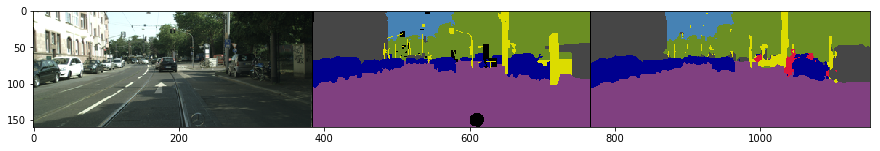

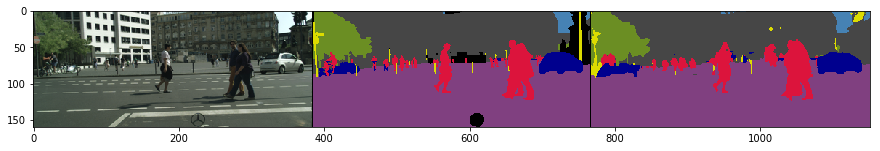

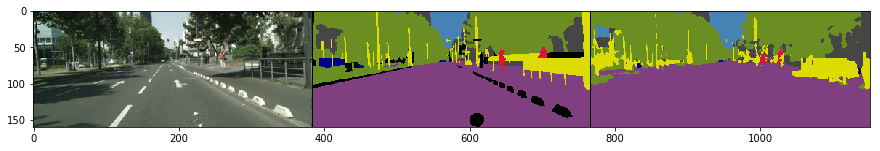

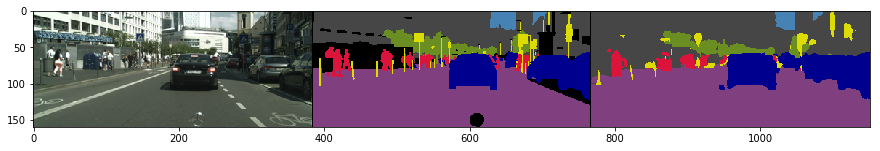

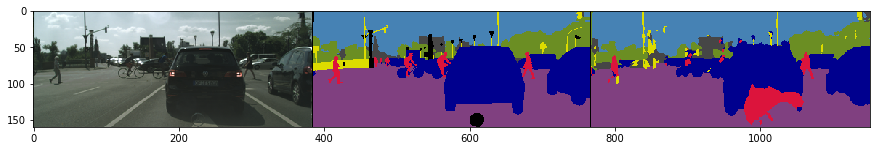

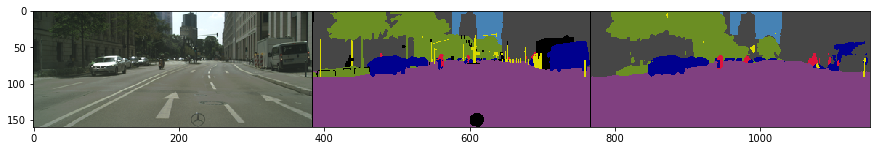

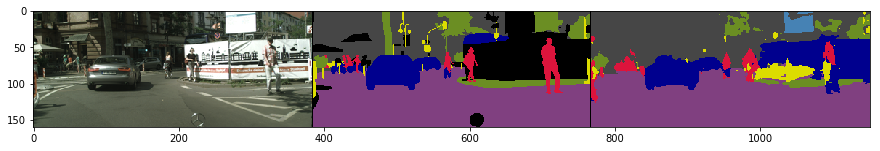

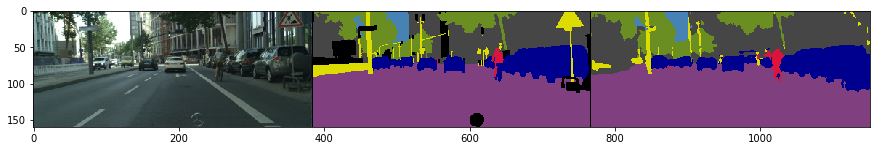

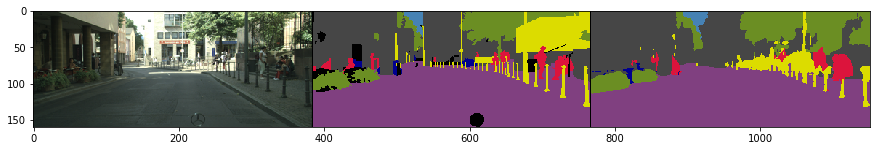

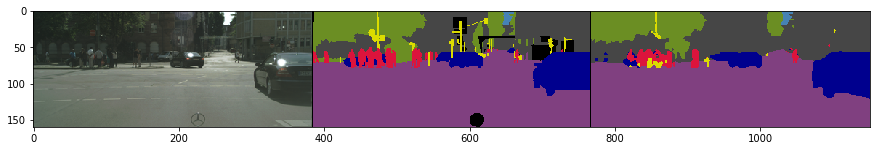

batch 000 loss = 0.30  (507.5 images/sec)
batch 010 loss = 0.31  (517.9 images/sec)
batch 020 loss = 0.36  (516.9 images/sec)
batch 030 loss = 0.17  (500.7 images/sec)
batch 040 loss = 0.19  (519.5 images/sec)
[[11582920    40941    25816    26418      222    22453    61852]
 [   77441  6246505   138818   218758    44557    40271   100506]
 [   42025   356662   373558   122759     5554    31484    53903]
 [   75027   237562    60562  5027027    18976    11137    36566]
 [       1    24017     2180    14694   865468       22      489]
 [   16129    57830    16246    11762       26   331218    45777]
 [   48792   104950    23402    33469      897    47395  2297136]]

 Validation  evaluation metrics:
	road IoU accuracy = 96.36 %
	building IoU accuracy = 81.24 %
	infrastructure IoU accuracy = 29.81 %
	nature IoU accuracy = 85.28 %
	sky IoU accuracy = 88.57 %
	person IoU accuracy = 52.43 %
	vehicle IoU accuracy = 80.46 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 73.45 %
Validat

73.451252278696288

In [17]:
# restore the best checkpoint
checkpoint_path = 'local/pretrained2/model.ckpt'
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)
validate(sess, val_data, x, y, y_pred, loss, draw_steps=10)

## 5. Homework

If you wish you can play with the model. Try to improve on the current IoU.